Документация по пакету lifelines
https://lifelines.readthedocs.io/en/latest/

In [ ]:
!pip install lifelines

# Часть 1

Почему учет цензурированных случаев важен?

Распространенная ошибка заключается в том, что при анализе данных игнорируются наблюдения (те элементы выборки), для которых терминальное событие не наступило.

Рассмотрим случай, когда популяция фактически состоит из двух субпопуляций, $A$ и $B$.
* субпопуляция $A$ имеет очень маленькую продолжительность жизни, например, в среднем 2 года,
* субпопуляция $B$ имеет гораздо большую продолжительность жизни, скажем, в среднем 12 лет.

Мы не знаем этого различия заранее. При $t=10$, мы хотим исследовать среднюю продолжительность жизни для всей популяции.

На рисунке красными линиями обозначена продолжительность жизни особей, у которых наблюдалось терминальное событие, а синими линиями обозначена продолжительность жизни особей, для которых терминальное событие не наблюдалось (цензурированных справа).

Если необходимо оценить среднюю продолжительность жизни в данной популяции, и мы наивно решим не включать особей сензурированных справо, то мы, очевидно, недооценим истинную среднюю продолжительность жизни. То есть полученная оценка будет смещенной (*англ*. biased) влево.

Observed lifetimes at time 10:
 [10.          4.32015306  1.16260646  5.08771778  9.2875173  10.
 10.         10.          9.81608777  2.64927869  6.90045442 10.
  4.50011173  0.47805454 10.          6.55966439  1.52356003  0.75817894
  3.59908744 10.          2.75796753 10.          7.12817237  0.69518732
  1.67153891]


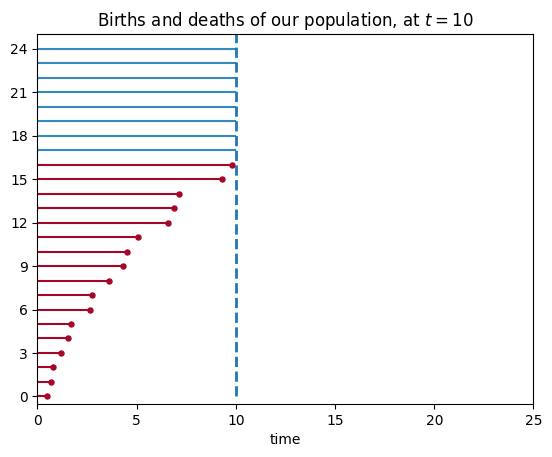

In [ ]:
from lifelines.plotting import plot_lifetimes
import numpy as np
from numpy.random import uniform, exponential

np.random.seed(1)
N = 25

CURRENT_TIME = 10

actual_lifetimes = np.array([
    exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)
])
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)

ax.set_xlim(0, 25)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Births and deaths of our population, at $t=10$")
print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

In [ ]:
print(np.sort(actual_lifetimes.round(2)))

[ 0.48  0.7   0.76  1.16  1.52  1.67  2.65  2.76  3.6   4.32  4.5   5.09
  6.56  6.9   7.13  9.29  9.82 13.32 13.87 14.14 15.29 16.64 18.69 25.26
 25.26]


(0.0, 30.0)

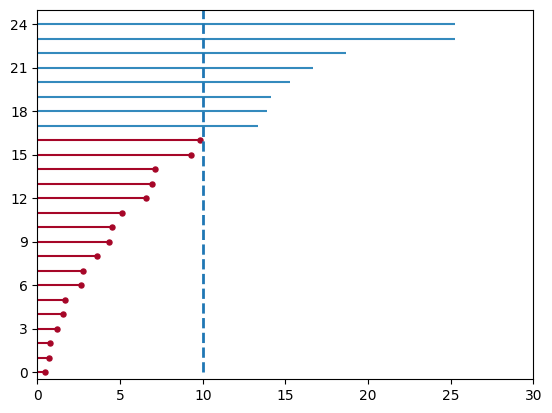

In [ ]:
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlim(0, 30)

# Часть 2

# Оценки функции выживаемости методом Каплана-Мейера

In [ ]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

from lifelines.datasets import load_dd

data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [ ]:
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

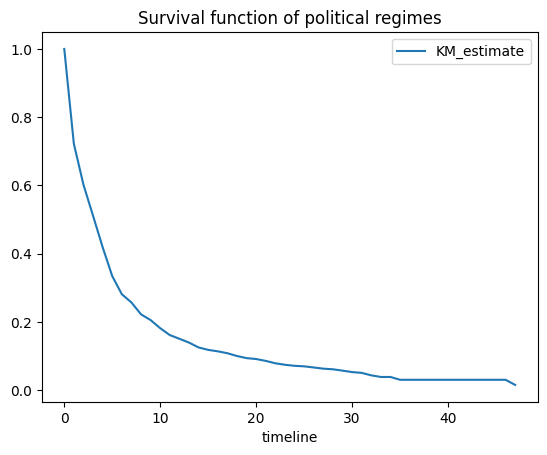

In [ ]:
from matplotlib import pyplot as plt


kmf.survival_function_.plot()
plt.title('Survival function of political regimes')

<Axes: xlabel='timeline'>

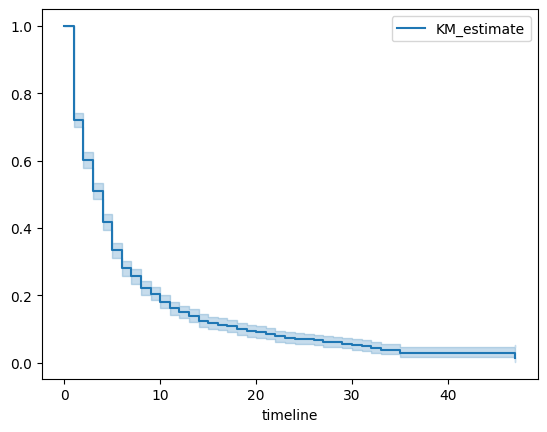

In [ ]:
kmf.plot_survival_function()

In [ ]:
kmf.median_survival_time_

4.0

In [ ]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)

In [ ]:
median_ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,3.0,4.0


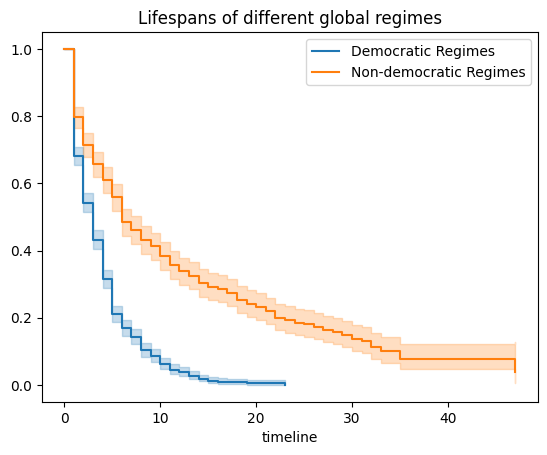

In [ ]:
ax = plt.subplot(111)

dem = (data["democracy"] == "Democracy")

kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different global regimes");

Использование теста log rank для проверки проверки значимости отличий функций риска в двух группах.

In [ ]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], E[dem], E[~dem], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

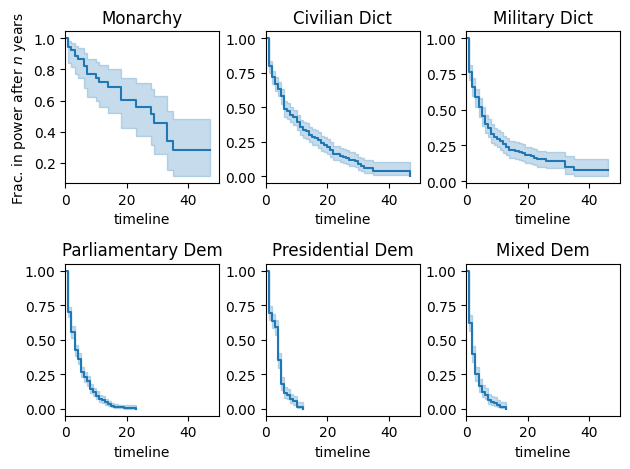

In [ ]:
regime_types = data['regime'].unique()

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = data['regime'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()

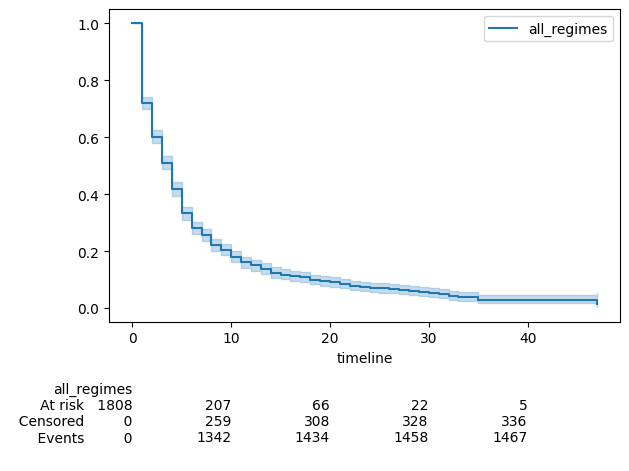

In [ ]:
kmf = KaplanMeierFitter().fit(T, E, label="all_regimes")
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

# Оценка риска с методом Нельсона-Аалена

$$
H(t) = \int_0^t h(\tau) d \tau
$$

In [ ]:
T = data["duration"]
E = data["observed"]

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 1808 total observations, 340 right-censored observations>

          NA_estimate
timeline             
0.0          0.000000
1.0          0.325912
2.0          0.507356
3.0          0.671251
4.0          0.869867


<Axes: xlabel='timeline'>

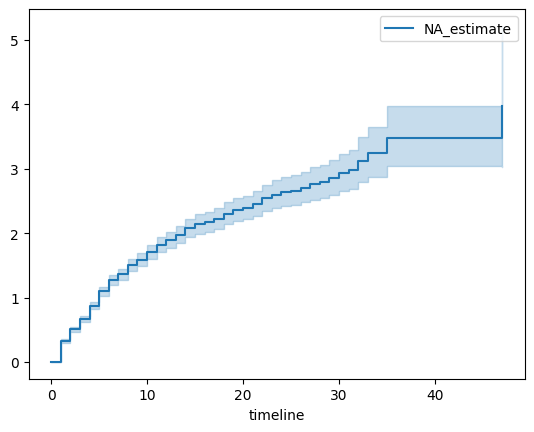

In [ ]:
print(naf.cumulative_hazard_.head())
naf.plot_cumulative_hazard()

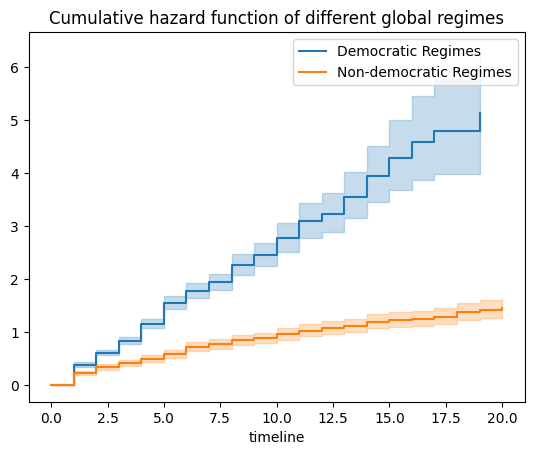

In [ ]:
dem = (data["democracy"] == "Democracy")
naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_cumulative_hazard(loc=slice(0, 20))

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_cumulative_hazard(ax=ax, loc=slice(0, 20))

plt.title("Cumulative hazard function of different global regimes");

Интерпретация кумулятивной функции риска сложна. Удобнее для интерпретации функция риска, она интуитивно понятнее.

С другой стороны, большая часть анализа выживаемости выполняется с использованием кумулятивной функции риска, поэтому рекомендуется все же ее понимать.

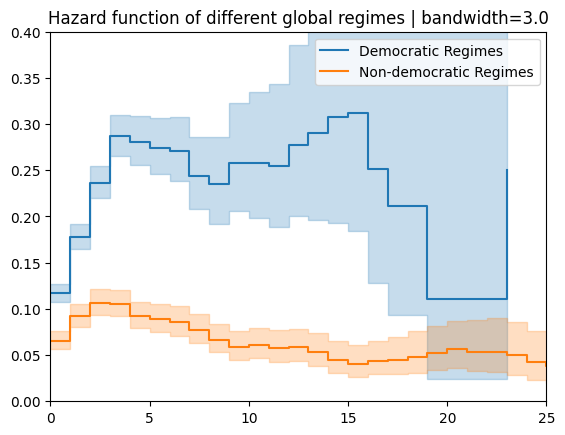

In [ ]:
bandwidth = 3.

naf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
ax = naf.plot_hazard(bandwidth=bandwidth)

naf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
naf.plot_hazard(ax=ax, bandwidth=bandwidth)

plt.title("Hazard function of different global regimes | bandwidth=%.1f" % bandwidth);
plt.ylim(0, 0.4)
plt.xlim(0, 25);

# Часть 3

# Оценка кумулятивных рисков с использованием параметрических моделей

Подгонка к модели Вейбулла

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 163 total observations, 7 right-censored observations>
   number of observations = 163
number of events observed = 156
           log-likelihood = -672.06
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_  55.73       1.33            53.13            58.33
rho_      3.45       0.24             2.97             3.93

          cmp to     z      p   -log2(p)
lambda_     1.00 41.26 <0.005        inf
rho_        1.00 10.07 <0.005      76.83
---
AIC = 1348.12

Text(0.5, 1.0, 'Cumulative hazard of Weibull model; estimated parameters')

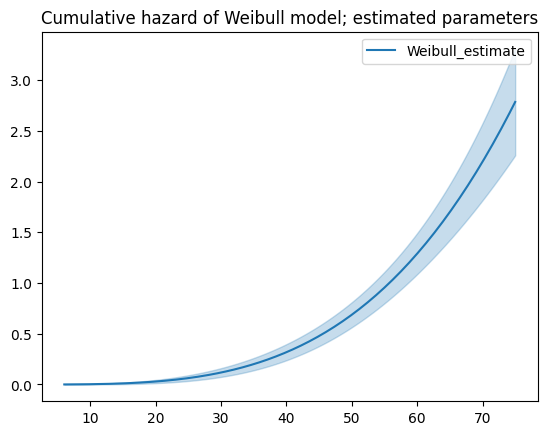

In [ ]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

data = load_waltons()

T = data['T']
E = data['E']

wf = WeibullFitter().fit(T, E)

wf.print_summary()
ax = wf.plot_cumulative_hazard()
ax.set_title("Cumulative hazard of Weibull model; estimated parameters")

Кроме распределения Вейбула имеются и другие распределения, применяемые для приближения выборочной функции (кумулятивного) риска и выживаемости

<Axes: >

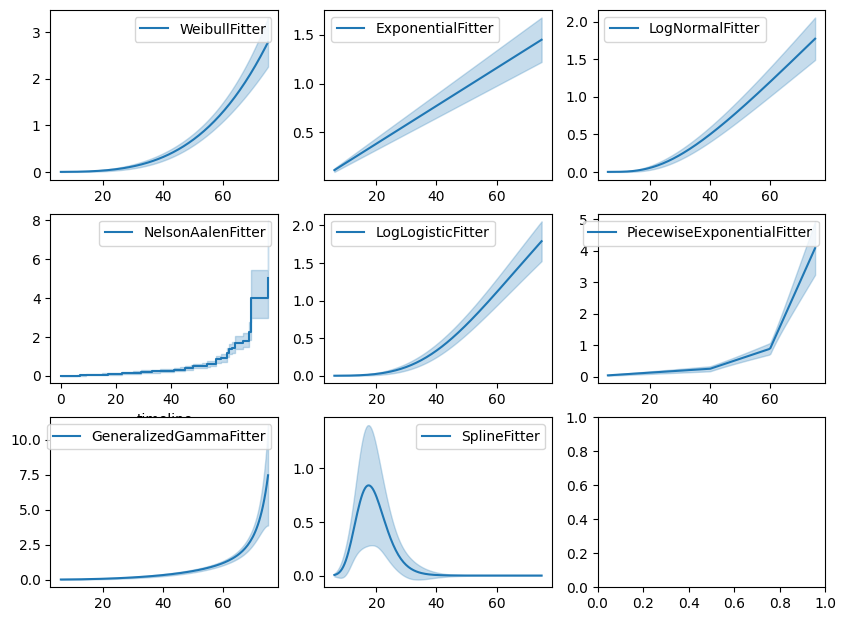

In [ ]:
from lifelines import (WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter,
PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter)

from lifelines.datasets import load_waltons
data = load_waltons()

fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

T = data['T']
E = data['E']

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])
gg.plot_cumulative_hazard(ax=axes[2][0])
spf.plot_cumulative_hazard(ax=axes[2][1])

<Axes: >

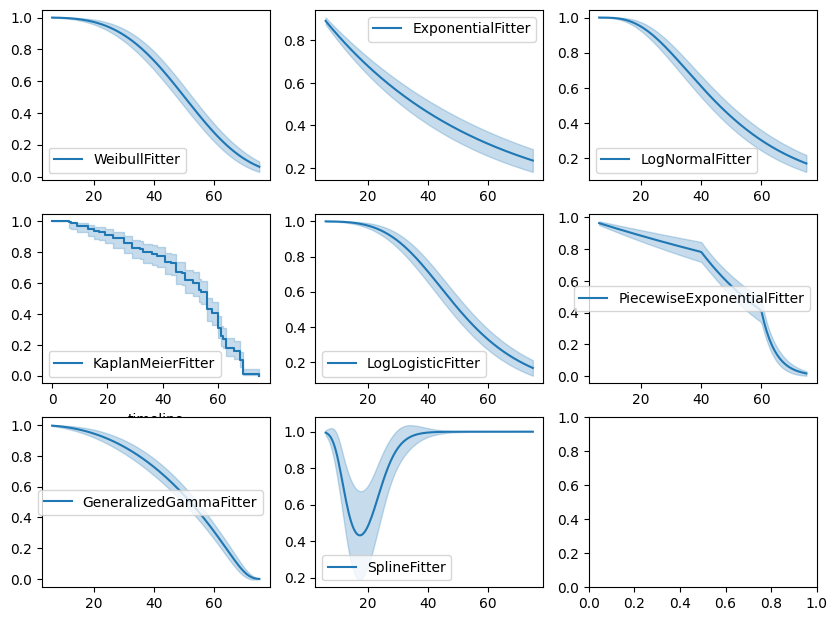

In [ ]:
from lifelines import KaplanMeierFitter

fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

T = data['T']
E = data['E']

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1])

# Часть 4

Регрессия Кокса

In [ ]:
from lifelines.datasets import load_rossi

rossi = load_rossi()

In [ ]:
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [ ]:
from lifelines import CoxPHFitter

rossi = load_rossi()

cph = CoxPHFitter()
cph.fit(rossi[['age', 'prio', 'week', 'arrest']], duration_col='week', event_col='arrest')
#cph.fit(rossi, duration_col='week', event_col='arrest')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -662.54
         time fit was run = 2023-05-24 15:28:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        -0.07       0.93       0.02            -0.11            -0.03                 0.90                 0.97
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 -3.33 <0.005      10.19
prio          0.00  3.49 <0.005      11.03
---
Concordance = 0.63
Partial AIC = 1329.08
log-likelihood ratio test = 25.68 on 2 df
-log2(p) of ll-ratio test = 18.52

In [ ]:
cph.fit(rossi, duration_col='week', event_col='arrest', formula="fin + age * prio")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -660.04
         time fit was run = 2023-05-24 15:27:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.33       0.72       0.19            -0.70             0.05                 0.50                 1.05
age        -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
prio        0.31       1.36       0.17            -0.03             0.64                 0.97                 1.91
age:prio   -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01

            cmp to     z    p   -log2(p)
covariate                               
fin           0.00 -1.72 0.09       3.54
age           0.00 -1.28 0.20       2.32
prio          0.00  1.79 0.07       3.78
age:prio      0.00 -1.23 0.22       2.18
---
Concordance = 0.63
Partial AIC = 1328.07
log-likelihood ratio test = 30.69 on 4 df
-log2(p) of ll-ratio test = 18.11

In [ ]:
X = rossi

result = cph.predict_survival_function(X)
#cph.predict_median(X)
#cph.predict_partial_hazard(X)

In [ ]:
X.iloc[0:5,:]

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [ ]:
result.iloc[:,0:5]

,0,1,2,3,4
1.0,0.998281,0.994860,0.992311,0.998123,0.997009
2.0,0.996562,0.989735,0.984665,0.996246,0.994021
3.0,0.994845,0.984635,0.977075,0.994372,0.991040
4.0,0.993128,0.979553,0.969532,0.992499,0.988064
5.0,0.991410,0.974484,0.962028,0.990624,0.985090
6.0,0.989690,0.969427,0.954560,0.988746,0.982115
7.0,0.987965,0.964375,0.947119,0.986865,0.979137
8.0,0.979367,0.939445,0.910686,0.977490,0.964345
9.0,0.975899,0.929515,0.896307,0.973711,0.958407
10.0,0.974165,0.924575,0.889182,0.971822,0.955443
